# Finding Best ML Algorithm for House Price Prediction using k Cross Validation and GridSearchCV. 

In machine learning, we couldn’t fit the model on the training data and can’t say that the model will work accurately for the real data. For this, we must assure that our model got the correct patterns from the data, and it is not getting up too much noise. For this purpose, we use the cross-validation technique.Cross-validation is a technique in which we train our model using the subset of the data-set and then evaluate using the complementary subset of the data-set.

### Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [72]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline 
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

In [73]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")

In [74]:
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [75]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [76]:
df2 = df1.drop(['area_type','society','balcony','availability'] , axis="columns")

In [77]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Data Cleaning: Handling NA/Null values

In [78]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [79]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [80]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

### Feature Engineering

 Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself 

In [81]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

<ipython-input-81-4c4c73fbe7f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [82]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [83]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [84]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [85]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [86]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


##### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple 

In [87]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
        

In [88]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)

In [89]:
df5 = df4.copy()

##### Add new feature called price per square feet

In [90]:
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']

In [91]:
len(df5.location.unique())

1304

####  Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [92]:
df5.location = df5.location.apply(lambda x: x.strip())

In [93]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)

In [94]:
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [95]:
len(location_stats[location_stats<=10])

1052

## Dimensionality Reduction

#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [96]:
location_stats_less_10 = location_stats[location_stats<=10]

In [97]:
location_stats_less_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [98]:
len(df5.location.unique())

1293

In [99]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_10 else x)

In [100]:
len(df5.location.unique())

242

In [101]:
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


## Outlier Removal Using Business Logic

In [102]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


##### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [103]:
df5.shape

(13246, 7)

In [104]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]

In [105]:
df6.shape

(12502, 7)

### Outlier Removal Using Standard Deviation and Mean

In [106]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [107]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out    

In [108]:
df7 = remove_pps_outliers(df6)

In [109]:
df7.shape

(10241, 7)

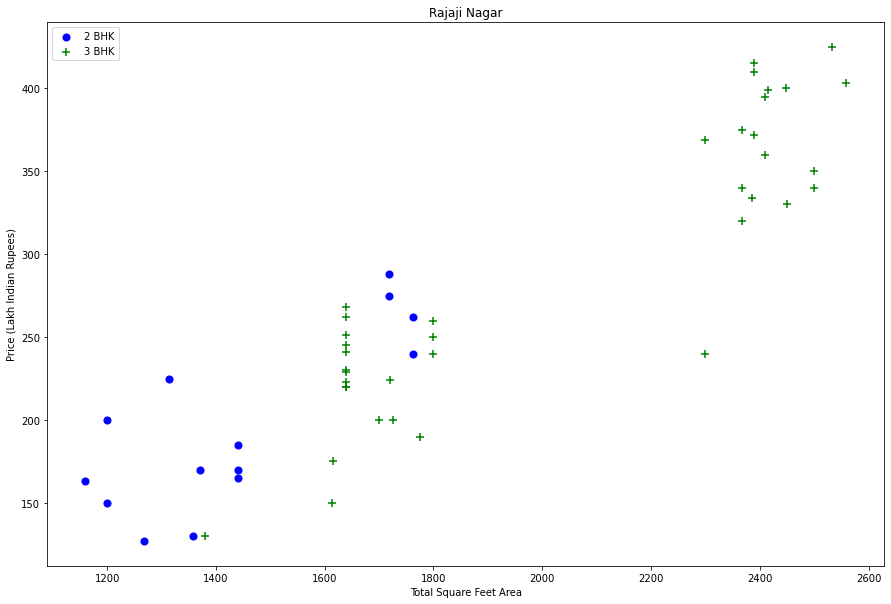

In [110]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

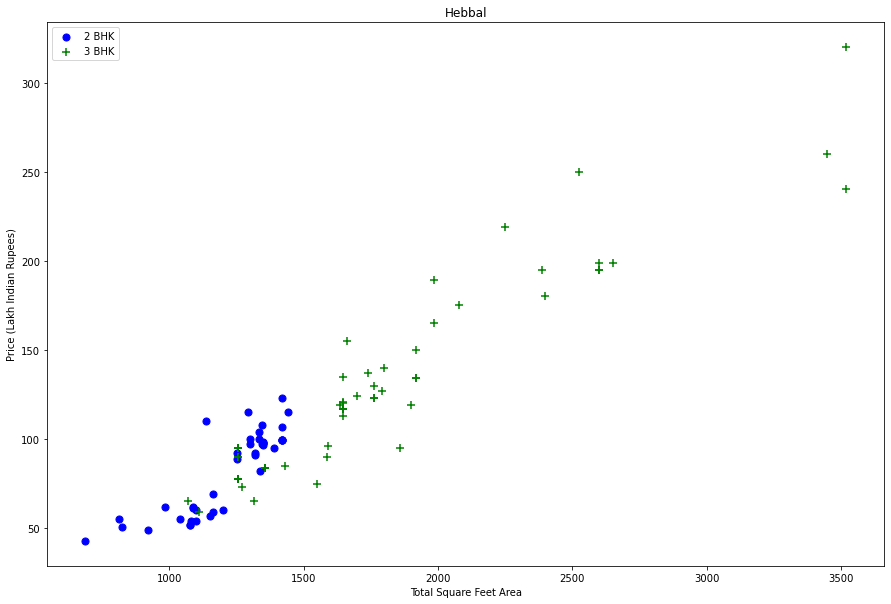

In [111]:
plot_scatter_chart(df7,"Hebbal")

In [112]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location,location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk,bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean':np.mean(bhk_df.price_per_sqft),
                'std':np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            }
        for bhk,bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')       

In [113]:
df8 = remove_bhk_outliers(df7)

In [114]:
df8.shape

(7329, 7)

### Outlier Removal Using Bathrooms Feature

In [115]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

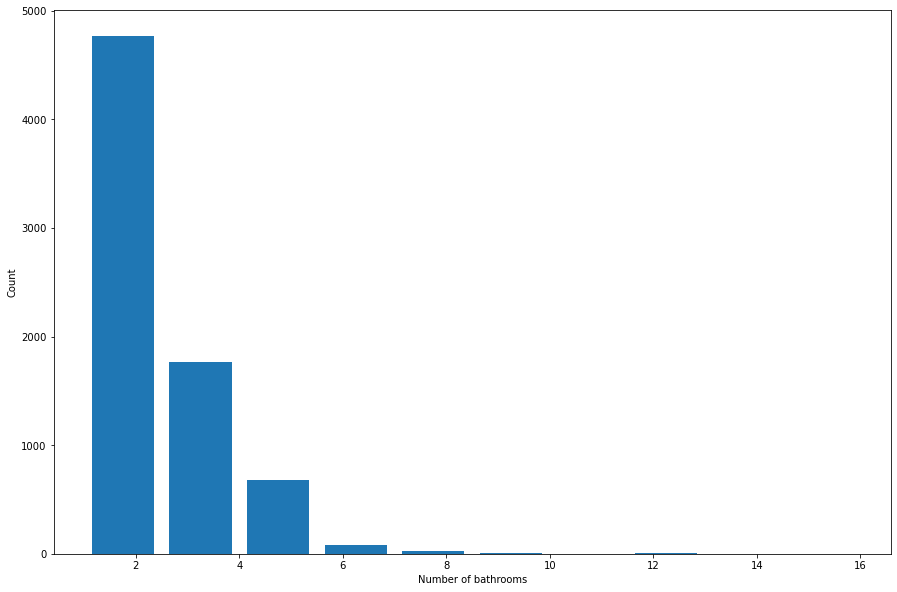

In [116]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [117]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


#####  It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [118]:
df8[df8.bath>df8.bhk + 2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [119]:
df9 = df8[df8.bath < df8.bhk + 2]

In [120]:
df9.shape

(7251, 7)

In [121]:
df9

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10232,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10233,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10236,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10237,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [122]:
df10 = df9.drop(['size','price_per_sqft'],axis = 'columns')

In [123]:
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


### Using One Hot Encoding For Location

###### For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [124]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df11 = pd.concat([df10,dummies],axis = 'columns')

In [126]:
df11 = df11.drop(['other'],axis = 'columns')

In [127]:
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
df12 = df11.drop(['location'],axis = 'columns')

In [129]:
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
df12.shape


(7251, 245)

In [131]:
X = df12.drop('price',axis='columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
y = df12.price
y

0        428.0
1        194.0
2        235.0
3        130.0
4        148.0
         ...  
10232     70.0
10233    200.0
10236    110.0
10237     26.0
10240    400.0
Name: price, Length: 7251, dtype: float64

In [133]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 10)

In [134]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8452277697873348

## Use K Fold cross validation to measure accuracy of our LinearRegression model

In this method, we split the data-set into k number of subsets(known as folds) then we perform training on the all the subsets but leave one(k-1) subset for the evaluation of the trained model. In this method, we iterate k times with a different subset reserved for testing purpose each time.
Always remember, a lower value of k is more biased, and hence undesirable. On the other hand, a higher value of K is less biased, but can suffer from large variability. It is important to know that a smaller value of k always takes us towards validation set approach, whereas a higher value of k leads to LOOCV approach.

In [135]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

## Find best model using GridSearchCV 

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': False}
1,lasso,0.687430,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.720273,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


#### Based on above results we can say that LinearRegression gives the best score. Hence we will use that. 

#### Test the model for few properties 

In [137]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr_clf.predict([x])[0]    
      

In [138]:
predict_price('1st Phase JP Nagar',1000,2,2)

83.49904676591962

In [139]:
predict_price('Indira Nagar',1000, 3, 3)

184.58430202040012